I am going to use an example time-series retail sales data from prophet (facebook) to explore some forecasting methods in this notebook.

In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

In [2]:
# load data
url = 'https://github.com/facebook/prophet/blob/main/examples/example_retail_sales.csv?raw=true'
data = pd.read_csv(url)
data.head()

,ds,y
0,1992-01-01,146376
1,1992-02-01,147079
2,1992-03-01,159336
3,1992-04-01,163669
4,1992-05-01,170068


The data contains two columns (no exogenous variables). 'ds' is the date column and 'y' is the sales amount in USD.

In [3]:
# format data
data['ds'] = pd.to_datetime(data['ds']) # convert to datetime
data.columns = ['date', 'sales'] # rename columns
data.head()

,date,sales
0,1992-01-01,146376
1,1992-02-01,147079
2,1992-03-01,159336
3,1992-04-01,163669
4,1992-05-01,170068


<Axes: title={'center': 'Retail Sales'}, xlabel='Date', ylabel='Sales ($)'>

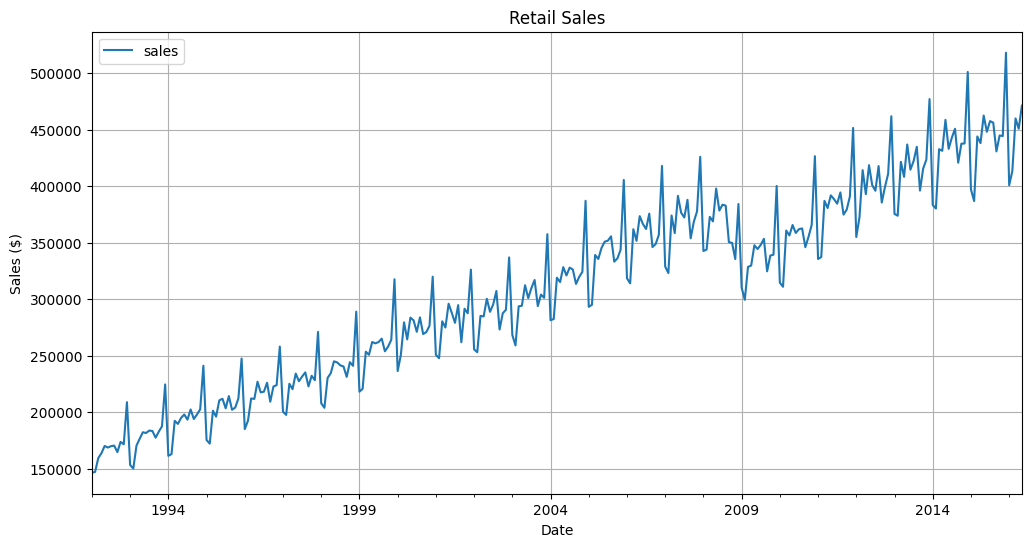

In [4]:
# plot data 
data.plot(x='date', y='sales', figsize=(12,6), title='Retail Sales', xlabel='Date', ylabel='Sales ($)', grid=True)

At first glance, we can see that the data has a trend (mean sales amount is changing) and it also has a seasonal component (spikes at ~ 1 year interval).

We will try differencing (first order to remove trend)

In [5]:
# let's now do a Dickey-Fuller test on the differenced data (first order differencing)
data['sales_diff'] = data['sales'].diff()
data['sales_diff'].dropna(inplace=True)
result = adfuller(data['sales_diff'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.437937
p-value: 0.009732
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572


A p-value of 0.0097 suggests stationarity is achieved with first order differencing.
We still need to look at seasonality and figure out the order for AR(p) and MA(q).

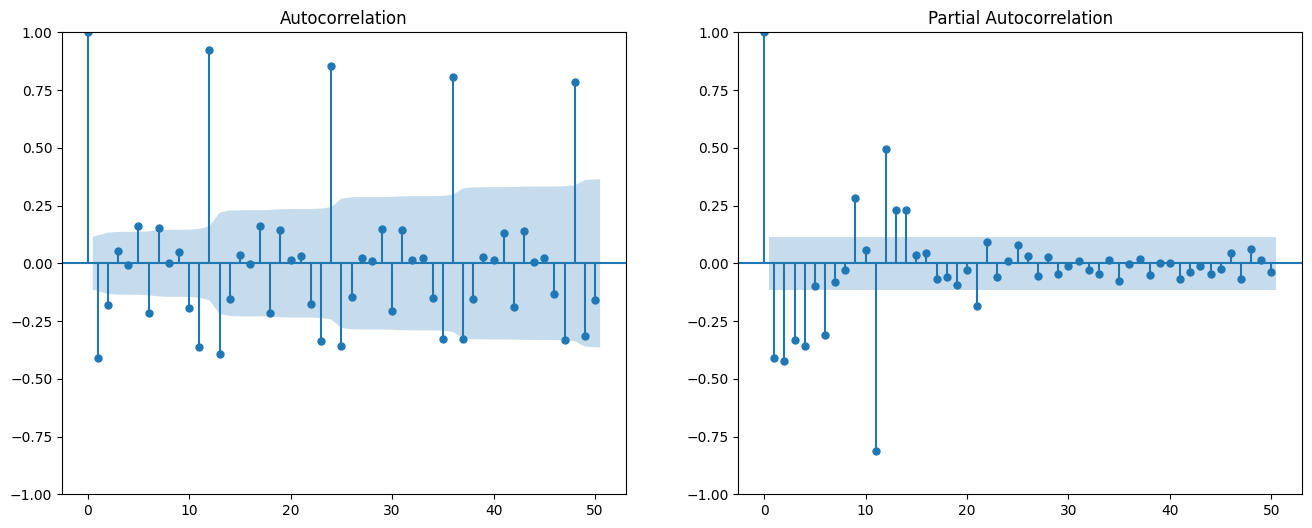

In [6]:
# Plotting ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(data['sales_diff'].dropna(), lags=50, ax=axes[0])

plot_pacf(data['sales_diff'].dropna(), lags=50, ax=axes[1])
plt.show()

ACF plots show seasonality. First peak at 1 is expected. Second dip and a few significant dips : I am not sure about

PACF plots show gradual decay. Expect MA order of 2 or more.

For detailed analysis, I am going to use auto_arima from pmdarima. Check out [this reference](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for full documentation.

In [7]:
# autoarima
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

model = auto_arima(data['sales'], seasonal=True, m=12, d = 1, suppress_warnings=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  293
Model:             SARIMAX(1, 1, 2)x(2, 1, [1], 12)   Log Likelihood               -2887.981
Date:                              Sun, 16 Mar 2025   AIC                           5789.962
Time:                                      20:09:02   BIC                           5815.406
Sample:                                           0   HQIC                          5800.167
                                              - 293                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7115      0.243     -2.926      0.003      -1.188      -0.235
ma.L1          0.5835      0.253      2.307      0.021       0.088       1.079
ma.L2         -0.1542      0.030     -5.116      0.000      -0.213      -0.095
ar.S.L12       0.4874      0.100      4.859      0.000       0.291       0.684
ar.S.L24      -0.1056      0.027     -3.847      0.000      -0.159      -0.052
ma.S.L12      -0.6134      0.109     -5.644      0.000      -0.826      -0.400
sigma2       5.15e+07   5.04e-09   1.02e+16      0.000    5.15e+07    5.15e+07
===================================================================================
Ljung-Box (L1) (Q):                  23.23   Jarque-Bera (JB):                 7.36
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               1.53   Skew:                            -0.18
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.23e+31. Standard errors may be unstable.
"""

There is a lot to unpack here. To break this down, let's look at the best model selection.

SARIMAX(1,1,2)x(2,1,[1],12): 

ARMA(1,1,2) is found to be best model. i.e. AR(1) and MA(2) with first order differencing.

x(2,1,[1],12) : Seasonal differencing (D=1) with two seasonal AR terms (SAR(2)) and one seasonal MA term (SMA(1)) for the 12-month seasonality

Coefficients :
    All the coefficients are significant. 

    AR(1) = -0.7115: A strong negative autoregressive relationship.

    MA(1) = 0.5835, MA(2) = -0.1542: Suggests a complex moving average structure.
    
    Seasonal AR(12) = 0.4874 & Seasonal AR(24) = -0.1056: Highlights seasonality, with a moderate positive correlation at lag 12 and a smaller negative effect at lag 24.
    
    Seasonal MA(12) = -0.6134: Indicates strong seasonal moving average behavior.

In [8]:
# test train split
split_ratio = 0.8  # Use 80% of data for training
split_index = int(len(data) * split_ratio)
train, test = data.iloc[:split_index], data.iloc[split_index:]


In [9]:
# Define the SARIMAX model
model = sm.tsa.SARIMAX(
    train['sales'],  # Use sales data, as the model will handle differencing
    order=(1,1,2),  # (p,d,q)
    seasonal_order=(2,1,1,12),  # (P,D,Q,S) for 12-month seasonality from above
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
results = model.fit()

In [20]:
test['date']

234   2011-07-01
235   2011-08-01
236   2011-09-01
237   2011-10-01
238   2011-11-01
239   2011-12-01
240   2012-01-01
241   2012-02-01
242   2012-03-01
243   2012-04-01
244   2012-05-01
245   2012-06-01
246   2012-07-01
247   2012-08-01
248   2012-09-01
249   2012-10-01
250   2012-11-01
251   2012-12-01
252   2013-01-01
253   2013-02-01
254   2013-03-01
255   2013-04-01
256   2013-05-01
257   2013-06-01
258   2013-07-01
259   2013-08-01
260   2013-09-01
261   2013-10-01
262   2013-11-01
263   2013-12-01
264   2014-01-01
265   2014-02-01
266   2014-03-01
267   2014-04-01
268   2014-05-01
269   2014-06-01
270   2014-07-01
271   2014-08-01
272   2014-09-01
273   2014-10-01
274   2014-11-01
275   2014-12-01
276   2015-01-01
277   2015-02-01
278   2015-03-01
279   2015-04-01
280   2015-05-01
281   2015-06-01
282   2015-07-01
283   2015-08-01
284   2015-09-01
285   2015-10-01
286   2015-11-01
287   2015-12-01
288   2016-01-01
289   2016-02-01
290   2016-03-01
291   2016-04-01
292   2016-05-

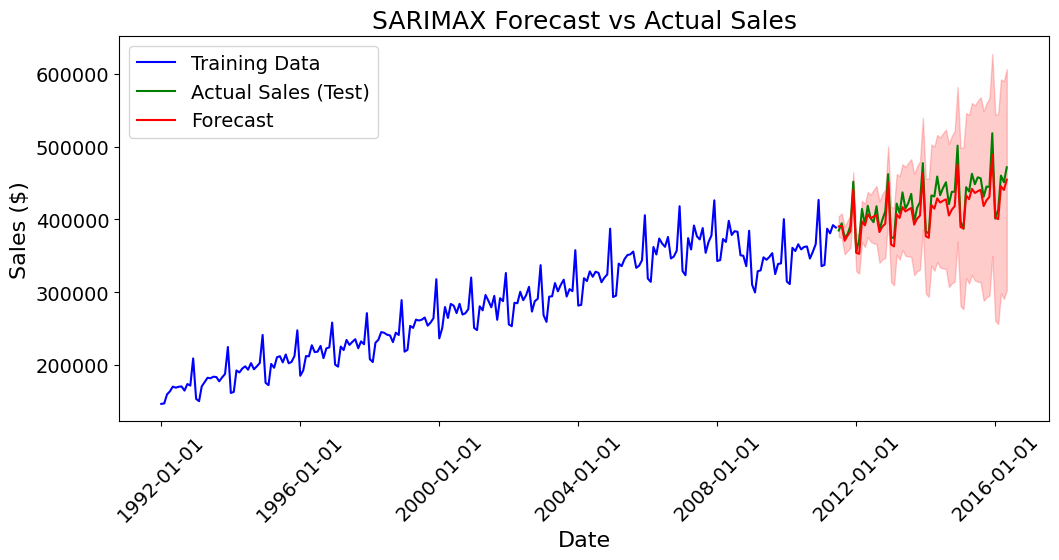

In [27]:
forecast_steps = len(test)  # Forecast same number of steps as test set
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = test.index

# Extract confidence intervals
forecast_ci = forecast.conf_int()
forecast_mean = forecast.predicted_mean

# Plot the results
plt.figure(figsize=(12,5))
fontsize = 16
plt.plot(train['date'], train['sales'], label="Training Data", color='blue')
plt.plot(test['date'], test['sales'], label="Actual Sales (Test)", color='green')
plt.plot(test['date'], forecast_mean, label="Forecast", color='red')
plt.fill_between(test['date'], forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='red', alpha=0.2)
plt.xlabel('Date', fontsize=fontsize)
plt.ylabel('Sales ($)', fontsize=fontsize)
plt.xticks(fontsize=fontsize-2, rotation=45)
plt.yticks(fontsize=fontsize-2)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.legend(fontsize=fontsize-2)
plt.title('SARIMAX Forecast vs Actual Sales', fontsize=fontsize+2)
plt.savefig('forecast_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
# Evaluate the model
forecast_accuracy = forecast_mean - test['sales']
mae = forecast_accuracy.abs().mean()
mape = (forecast_accuracy / test['sales']).abs().mean()
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2%}")


Mean Absolute Error: 12417.14
Mean Absolute Percentage Error: 2.86%
